<a href="https://colab.research.google.com/github/quantaosun/pl3/blob/main/Free_Cloud_Docking_multiple_docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programmatic Molecular Docking- Mulitiple small molecules

### Based on Vina-derived Smina. Obabel is used to calculate the protein charges. The docking grid is defined as the centre of the native ligand.

- This notebook is written by https://github.com/quantaosun
- what you get is ***a list of the docking score + docked complex*** 
- the docked list provide you an idea which ligand may binds the best relavely, so you can move on to the single molecule docking for the best structure among several you have provided.

- Note you should provide a SMILES list

# Install conda

In [ ]:
#@title Conda installation
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


# Please provide PDB ID and ligand structure you want to dock with

In [ ]:
smiles_list = [
    'Cc1ccc(CN(C)C(=O)c2ccccc2)cc1N3CCN(CC3)C',
    'Cc1ccc(C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)Nc2ccccc2)cc1'
]

In [ ]:
#@title Input expected from the user
path = "." #@param {type:"string"}
%cd '{path}'
PDB_ID = "7L10" #@param {type:"string"}
pdb = PDB_ID + ".pdb"
! wget https://files.rcsb.org/download/$pdb
#@title Ligand three-letter name
Ligand = "XEY" #@param {type:"string"}
#smiles = "OC1=CC=CC=C1C2=CN(C(C(C3=CC(Cl)=CC(F)=C3)=C2)=O)C4=CC=CN=C4" #@param {type:"string"}


/content
--2023-02-17 20:41:06--  https://files.rcsb.org/download/7L10.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.70
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7L10.pdb’

7L10.pdb                [ <=>                ] 241.42K  --.-KB/s    in 0.03s   

2023-02-17 20:41:06 (7.45 MB/s) - ‘7L10.pdb’ saved [247212]



# Install dependencies

In [ ]:
#@title Install independencies
!conda install -c rdkit rdkit -y 2>&1 1>/dev/null
!conda install -q -y -c openbabel openbabel 2>&1 1>/dev/null
!pip install py3Dmol 2>&1 1>/dev/null
!yes|conda install -c conda-forge pymol-open-source 2>&1 1>/dev/null
!conda install -c conda-forge prolif 2>&1 1>/dev/null
!conda install -c conda-forge mdanalysis # for 2D interaction visualization
!conda install -c conda-forge prolif # for 2D interaction
!conda install -c conda-forge pymol-open-source -y # Install pymol for 3D image making
!conda install -c anaconda scipy
!conda install -c anaconda scikit-learn
!conda install -c conda-forge matplotlib
!To install this package run one of the following:
!conda install -c anaconda seaborn
!wget --no-check-certificate https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static 2>&1 1>/dev/null
!chmod u+x smina.static
#!./smina.static -h
import sys
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
print(rdBase.rdkitVersion)

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.

Solving environment: - \ | / - \ | / - \ | / - \ | / 

In [ ]:
import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd
IPythonConsole.ipython_3d=True
%pylab inline

import py3Dmol

Populating the interactive namespace from numpy and matplotlib


# Prepare receptor

In [ ]:
#@title Write out a script for pymol
com_file = open('split.pml','w')
com_file.write('''
load 3HTB.pdb
remove resn HOH
h_add elem O or elem N
select 3HTB-JZ4, resn JZ4 #Create a selection called 1OYT-FSN from the ligand
select 3HTB-receptor, 3HTB and not 3HTB-JZ4 #Select all that is not the ligand
save 3HTB-JZ4.pdb, 3HTB-JZ4
save 3HTB-receptor.pdb, 3HTB-receptor    
''')
com_file.close()

In [ ]:
#@title Correct the script with right PDB ID and ligand name
!sed -i 's/3HTB/{PDB_ID}/g' split.pml
!sed 's/JZ4/{Ligand}/g' split.pml
!sed -i 's/JZ4/{Ligand}/g' split.pml


load 7L10.pdb
remove resn HOH
h_add elem O or elem N
select 7L10-XEY, resn XEY #Create a selection called 1OYT-FSN from the ligand
select 7L10-receptor, 7L10 and not 7L10-XEY #Select all that is not the ligand
save 7L10-XEY.pdb, 7L10-XEY
save 7L10-receptor.pdb, 7L10-receptor    


In [ ]:
#@title Run pymol to split protein and native ligand
%cd '{path}'
! pymol -c split.pml

/content
 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 2 CPU cores.  Enabled multithreaded rendering.
PyMOL>load 7L10.pdb
HEADER    VIRAL PROTEIN, HYDROLASE                13-DEC-20   7L10
TITLE     CRYSTAL STRUCTURE OF THE SARS-COV-2 (2019-NCOV) MAIN PROTEASE IN
TITLE    2 COMPLEX WITH COMP

# Variable assignment

In [ ]:
Protein_PDB_file_name = PDB_ID + '-receptor.pdb'
ligand_name = PDB_ID + '-' + Ligand + '.pdb'

# PDBFixer to prepare the receptor

In [ ]:
!conda install -c conda-forge openmm -y

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - openmm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ocl-icd-2.3.1              |       h7f98852_0         119 KB  conda-forge
    ocl-icd-system-1.0.0       |                1           4 KB  conda-forge
    openmm-8.0.0               |   py38he9472fe_0        10.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        10.8 MB

The following NEW packages will be INSTALLED:

  ocl-icd            conda-forge/linux-64::ocl-icd-2.

In [ ]:
!conda install -c conda-forge pdbfixer

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pdbfixer


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pdbfixer-1.8.1             |     pyh6c4a22f_0         498 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         498 KB

The following NEW packages will be INSTALLED:

  pdbfixer           conda-forge/noarch::pdbfixer-1.8.1-pyh6c4a22f_0 



                                                                        
Preparing transaction: - done
Verifying transaction: | done
Executing transaction

In [ ]:
!pdbfixer --help

Usage: pdbfixer
       pdbfixer filename [options] 

When run with no arguments, it launches the user interface.  If any arguments are specified, it runs in command line mode.

Options:
  -h, --help            show this help message and exit
  --pdbid=PDBID         PDB id to retrieve from RCSB [default: None]
  --url=URL             URL to retrieve PDB from [default: None]
  --output=FILENAME     output pdb file [default: output.pdb]
  --add-atoms=ATOMS     which missing atoms to add: all, heavy, hydrogen, or
                        none [default: all]
  --keep-heterogens=OPTION
                        which heterogens to keep: all, water, or none
                        [default: all]
  --replace-nonstandard
                        replace nonstandard residues with standard equivalents
  --add-residues        add missing residues
  --water-box=X Y Z     add a water box. The value is the box dimensions in nm
                        [example: --water-box=2.5 2.4 3.0]
  --ph=PH          

In [ ]:
!pdbfixer  {Protein_PDB_file_name} --ph=7  --replace-nonstandard --add-residues 

In [ ]:
!cat output.pdb > receptor.pdb

# Caculating charges for receptor

In [ ]:
#@title Target and native ligand preparation before docking
#!obabel {Protein_PDB_file_name} -xr -O receptor.pdbqt
!obabel receptor.pdb -xr -O receptor.pdbqt
!obabel {ligand_name} -O native_ligand.pdbqt

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is receptor.pdb)

1 molecule converted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is 7L10-XEY.pdb)

1 molecule converted


# Paste your SMILES and Prepare ligand

In this script, the smiles_list variable contains the list of SMILES strings that you want to convert to an SDF file. The script creates a new SDWriter object to write the output SDF file, and then loops over each SMILES string in the list. For each SMILES string, it uses the Chem.MolFromSmiles function from RDKit to convert the SMILES to a molecule object. It then uses the AllChem.Compute2DCoords function to add 2D coordinates to the molecule, which can be useful for visualization. Finally, it sets a unique name for the molecule using the mol.SetProp('_Name', ...) method, and then writes the molecule to the output SDF file using the writer.write method.

The resulting SDF file will contain one molecule for each SMILES string in the input list, with a unique name assigned to each molecule based on its position in the list.

In [ ]:
#@title Generate sdf file, this sdf contains all the moclecule you have provided.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import SDWriter

# Define the list of SMILES strings


# Create a new SDWriter object to write the output SDF file
writer = SDWriter('small.sdf')

# Loop over each SMILES string in the list and convert it to a molecule object,
# then add it to the SDF file with a unique name
for i, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)  # Add 2D coordinates for visualization
    mol.SetProp('_Name', f'Molecule_{i+1}')
    writer.write(mol)

# Close the SDF writer
writer.close()

In [ ]:
#@title Define small ligand path and output molecule number
# File locations
sdfFilePath = 'small.sdf' #@param {type:"string"}
ConfoutputFilePath = 'small_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

2

In [ ]:
#@title SDF conformation generation for small molecule

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:00 |###############################|


In [ ]:
ms = [x for x in Chem.SDMolSupplier(ConfoutputFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
for m in ms: Chem.AssignAtomChiralTagsFromStructure(m)
len(ms) # check how many conformations

10

# Define Docking inputs variables

In [ ]:
#@title 👋 Input names needed for Dock1
ProteinForDocking = "receptor.pdbqt" #@param {type:"string"}
LigandFromProtein = "native_ligand.pdbqt" #@param {type:"string"}
Docked_out_FilePath = "All_Docked.sdf.gz" #@param {type:"string"}
FlexibleDockedFilePath = "FlexibleDocked.sdf.gz" #@param {type:"string"}

# Docking 

In [ ]:
#@title  Normal Docking (docking box is 8Å greater than the ligand specified. The –exhaustiveness is 8 )
!./smina.static --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}'  -o '{Docked_out_FilePath}'

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is 7L10-XEY.pdb)

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
************************************************

# Post-docking process

In [ ]:
%cd ..

/content


,minimizedAffinity,ID,Molecule
0,-6.14085,Molecule_1,
1,-6.07940,Molecule_1,
2,-6.06880,Molecule_1,
3,-6.03763,Molecule_1,
4,-5.99923,Molecule_1,
...,...,...,...
85,-7.96201,Molecule_2,
86,-7.90831,Molecule_2,
87,-7.90678,Molecule_2,
88,-7.73759,Molecule_2,

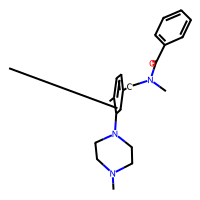
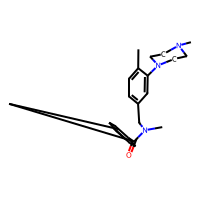
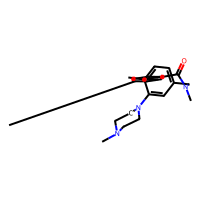
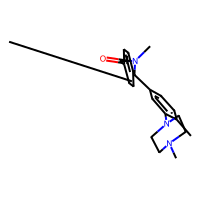
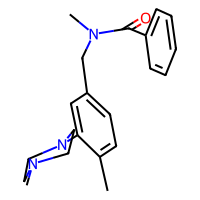
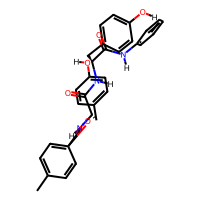
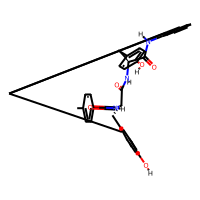
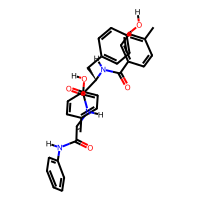
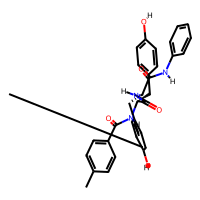
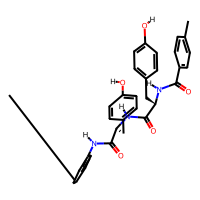

In [ ]:
docked_df = PandasTools.LoadSDF(Docked_out_FilePath,molColName='Molecule', removeHs=False)
docked_df

# Please download pre_pymol.pse to continue making the image with your local Pymol

# References

[A Jupyter Notebook to aid Docking to MurD protein](https://www.macinchem.org/reviews/JupyterDocking/jupyterdocking_files/JupyterDocking.html)

All the dependencies used are open soured, they are 

*   rdkit
*   openbabel
*   py3Dmol 
*   pymol-open-source 
*   smina.static
*   MDAnalysis
*   ProLif
*   Python 3.8
*   conda
*   colab conda

- This notebook has referred [Is life worth living](https://www.cheminformania.com/ligand-docking-with-smina/)
- Thi notebook has referred [Jupyter Notebook for docking either locally or using Colab](https://www.macinchem.org/reviews/JupyterDocking/jupyterdocking.php)
 